In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image
from skimage import io as skio


# POUR LA MORPHO
#from skimage.morphology import watershed
#from skimage.feature import peak_local_max



In [2]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES:
colaboratory=True #mettre True si vous utilisez google colab
notebook=False   # mettre Trus si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()






Loading BokehJS ...

--2025-01-17 11:32:29--  https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 2a04:8ec0:0:a::89c2:16e3, 137.194.22.227
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|2a04:8ec0:0:a::89c2:16e3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 290918 (284K) [application/x-gzip]
Saving to: ‘donnees_IMA203.tgz.6’

donnees_IMA203.tgz. 100%[===================>] 284.10K  --.-KB/s    in 0.02s   

2025-01-17 11:32:29 (13.3 MB/s) - ‘donnees_IMA203.tgz.6’ saved [290918/290918]

x donnees_IMA203/
x donnees_IMA203/lacornou.tif
x donnees_IMA203/lena.tif


In [3]:
import numpy as np
import tempfile
import IPython
import matplotlib.pyplot as plt
import PIL.Image as pil_image

def viewimage(im, normalize=True,titre='',displayfilename=False):
   imin=im.copy().astype(np.float32)
   if normalize:
       imin-=imin.min()
       if imin.max()>0:
           imin/=imin.max()
   else:
       imin=imin.clip(0,255)/255


   imin=(imin*255).astype(np.uint8)
   filename=tempfile.mktemp(titre+'.png')
   if displayfilename:
       print (filename)
   plt.imsave(filename, imin, cmap='gray')
   IPython.display.display(IPython.display.Image(filename))

#La fonction viewimage_color est la même que viewimage. Ca a l'air de marcher
#USE ONLY viewimage
def viewimage_color(im, normalize=True,titre='',displayfilename=False):
   imin=im.copy().astype(np.float32)
   if normalize:
       imin-=imin.min()
       if imin.max()>0:
           imin/=imin.max()
   else:
       imin=imin.clip(0,255)/255


   imin=(imin*255).astype(np.uint8)
   filename=tempfile.mktemp(titre+'.png')
   if displayfilename:
       print (filename)
   plt.imsave(filename, imin, cmap='gray')
   IPython.display.display(IPython.display.Image(filename))



In [4]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out

def degrade_image(im,br):
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py):
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))

    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]

    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser
# la fonctionnelle E2 par descente de gradient nous avons choisi
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive


def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """

    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=(np.zeros((sy,sx),dtype=complex))
    denom=(np.zeros((sy,sx),dtype=complex))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I):
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax):
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))

    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [5]:
#%% lire une image

im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())



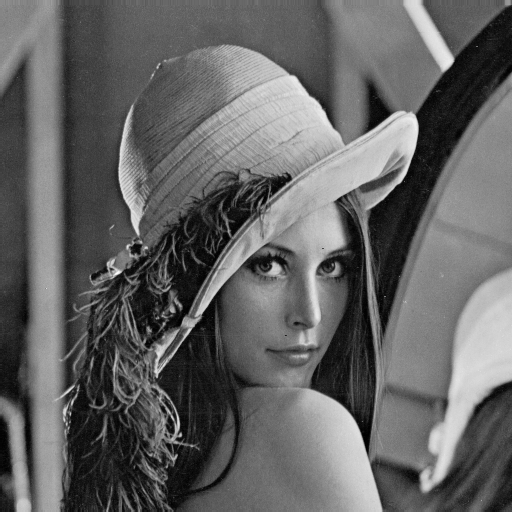

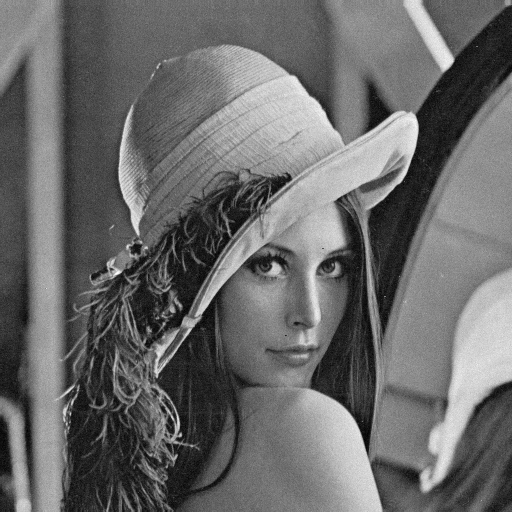

In [6]:
#%%

# voir l'image
viewimage(im,titre='ORIGINALE')
#degrader une image

imb=degrade_image(im,5)

# voir l'image bruitée
viewimage(imb,titre='BRUITEE')



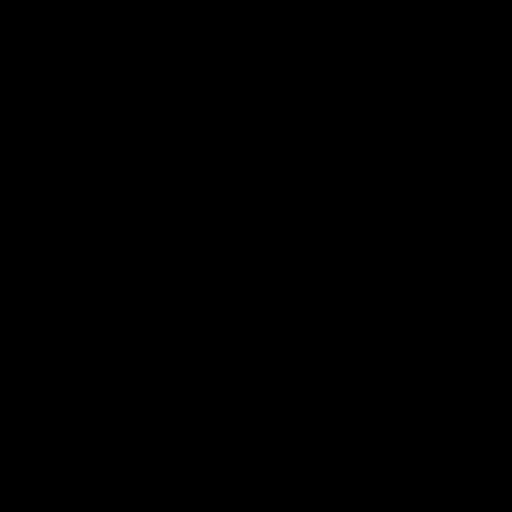

In [7]:
#%% restauration quadratique : exemple
lamb=1e100
restau=minimisation_quadratique(imb,lamb)
viewimage(restau,titre='RESTQUAD_LAMB='+str(lamb))



In [8]:
#%% COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs
# parametres de regularisation

errq=[]
errvt=[]
erreur=[]
vk=np.arange(0,0.25,0.01);
for k in vk:
    print (k)
    #restq=minimisation_quadratique(imb,10^(k));
    #errq.append[]=norm2(restq-myim);
    #restva=vartotale_Chambolle(imb,10**(k));
    restq=minimisation_quadratique(imb,10**(k))
    erreur.append(norm2(im-restq))
    #errvt.append(norm2(restva-myim));



#plt.plot(10**vk,errvt);




0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24


In [9]:
#%%
u1,en1=minimise_TV_gradient(imb, 40, 1, 20)
u05,en05=minimise_TV_gradient(imb, 40, 0.5, 20)
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 20)
#u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)


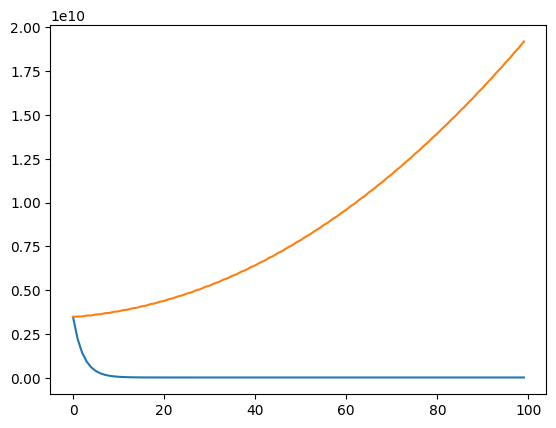

In [10]:
#%%
myim=imread('lena.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u,energ2)=minimise_TV_gradient(imb,1,1,100)       # pas = 1
plt.plot(energ)
plt.plot(energ2)


Q1. Comment utiliser l’outil **resoud_quad_fourier** pour trouver le minimiseur de cette
énergie (voir le programme **minimisation_quadratique**)?

**Answer**:
The python function `resoud_quad_fourier` takes as arguments $(K, V)$, where $K$ is a vector of $n$ kernels and $V$ is a vector of $n$ images. Then, it returns
$$
U = \arg \min_u \sum_{i = 1}^n \| K_i \ast u - V_i \|^2
$$
We can rewrite the quadratic energy function as the function above to make use of the `resoud_quad_fourier` to find the image that minimizes the energy.
Particularly,
$$
\lambda \| \nabla u \|^2 = \lambda \| \partial_x u \|^2 + \lambda \| \partial_y u \|^2 = \| \sqrt{\lambda} D_x \ast u \|^2 + \| \sqrt{\lambda} D_y \ast u \|^2 = \| \sqrt{\lambda} D_x \ast u - 0 \|^2 + \| \sqrt{\lambda} D_y \ast u - 0 \|^2
$$
where
$$
D_x = \begin{pmatrix}
1 & -1
\end{pmatrix}, \qquad
D_y = \begin{pmatrix}
1 \\ -1
\end{pmatrix}
$$
Moreover, $\| u - v \|^2 = \| \delta \ast u - v \|^2$, where $\delta = \begin{pmatrix} 1 \end{pmatrix}$.

$D_x$ and $D_y$ are precisely the kernels that differentiate the image. So, we can use the function `resoud_quad_fourier` with parameters $(\sqrt{\lambda} D_x, \sqrt{\lambda} D_y, \delta)$ and $(0, 0, \texttt{img})$ to find the minimizer. 

Q2. Décrire le résultat de ce débruitage lorsque $\lambda$ est très grand ou très petit

**Answer**: If $\lambda$ is very small, then the regularization has no effect, making the minimizer equal to the observed image:
$$
\lim_{\lambda \to 0} \| u - v \|^2 + \lambda \| \nabla u \|^2 = \| u - v \|^2 \implies \arg \min_u E_1(u) = v.
$$

If $\lambda$ is too big, then the data attachment term loses importance, making the image too regular (the gradient tends to 0). The result is a single-colored image, since there is no variation ($\nabla u = 0$).

Q3. Après avoir ajouté un bruit d’écart type $\sigma = 5$ à l’image de lena, trouver (par dichotimie) le paramètre $\lambda$ pour lequel $\| \tilde{u} - v \|^2 \sim \|u - v\|^2$. C’est-à-dire le paramètre pour lequel l’image reconstruite $\tilde{u}$ est à la même distance de l’image dégradée $v$ que ne l’est l’image parfaite. (on respecte la norme du bruit : La norme du bruit est connue même quand on ne connait pas l’image parfaite)

0.3308080808080808


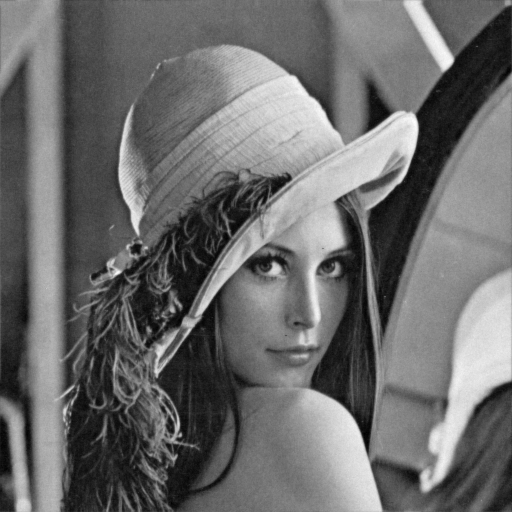

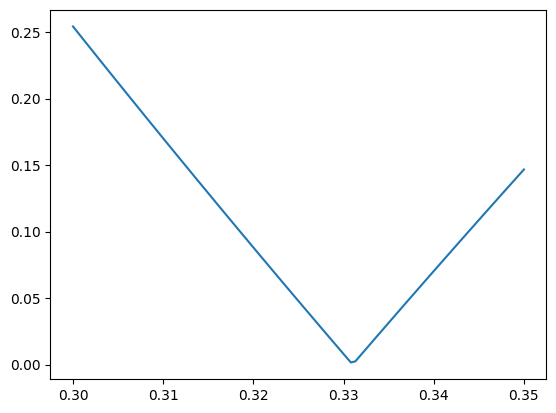

In [11]:
imb=degrade_image(im,5)
err = []

lambdas = np.linspace(0.3, 0.35, 100)
rests = []

for lambda_ in lambdas:
    restq = minimisation_quadratique(imb, lambda_)
    rests.append(restq)
    err.append(np.abs(norm2(imb - restq) / np.sqrt(imb.size) - 5))



plt.plot(lambdas, err)
print(lambdas[np.argmin(err)])
viewimage(rests[np.argmin(err)])

Q4. Ecrire un algorithme pour trouver le paramètre $\lambda$ tel que $\| \tilde{u} - u \|^2$ soit minimale. (dans le cadre de ce TP on connait l’image parfaite u, on général on ne la connait pas). Commentaires?

**Answer**: The obtained $\lambda$ is about half of the result from question 3. This might be because the original image has a lot of contours, and so the minimization of the error difference may not reflect the actual best restoration.

0.11676767676767677


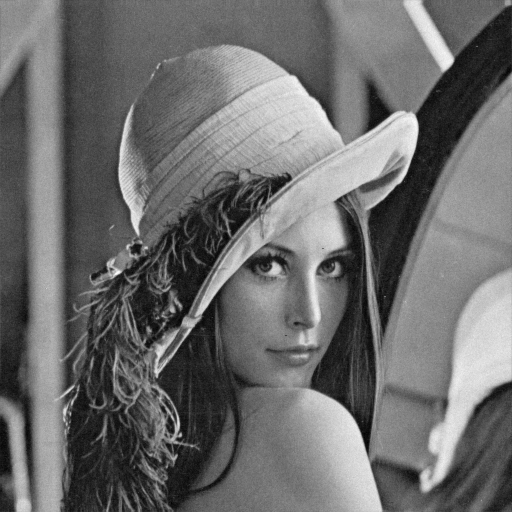

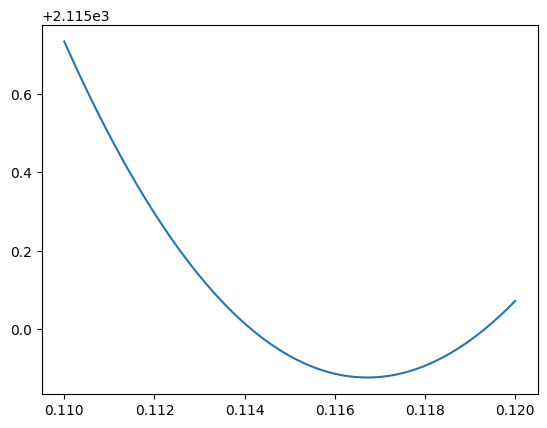

In [12]:
err = []

lambdas = np.linspace(0.11, 0.12, 100)
rests = []

for lambda_ in lambdas:
    restq = minimisation_quadratique(imb, lambda_)
    rests.append(restq)
    err.append(norm2(im - restq))

plt.plot(lambdas, err)

lambda_quad = lambdas[np.argmin(err)]
print(lambda_quad)
viewimage(rests[np.argmin(err)])

Q5. Utiliser le programme `minimise_TV_gradient` pour différentes valeurs du pas de descente. Atteignez-vous toujours le même minimum d’énergie? (le programme renvoie l’évolution de l’énergie).

**Answer**: Not all step sizes get to the same energy minimum. This happens because a step size too large may make the function diverge in the gradient descent algorithm.

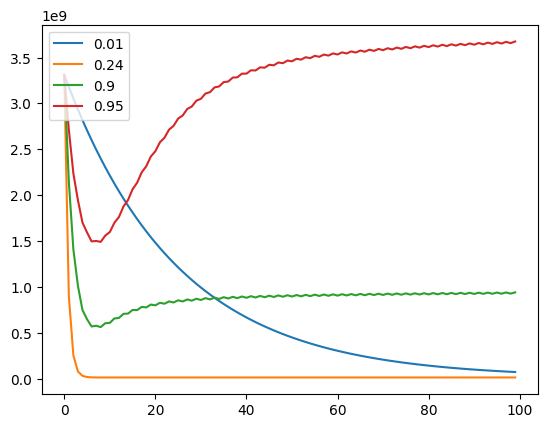

In [13]:
lambda_ = 4.7
step_sizes = [0.01, 0.24, 0.9, 0.95]
N_iters = 100

for step_size in step_sizes:
    u, Energs = minimise_TV_gradient(imb, lambda_, step_size, N_iters)
    plt.plot(Energs, label=f"{step_size}")
    #viewimage(u)

plt.legend(loc="upper left")

Q6. Le programme `vartotale_Chambolle` applique la méthodede **Chambolle** (expliquée dans le polycopié) au même problème posé par $E_2$. Utilisez ce programme et que constatez-vous quant à la vitesse de cette algorithme et sa précision (minimisation effective de $E_2$) par rapport à la descente de gradient.

**Answer**: The function `vartotale_Chambolle` returns the restored image almost instantly, while the gradient descent algorithm depends on the choice of the step size and the number of iterations.

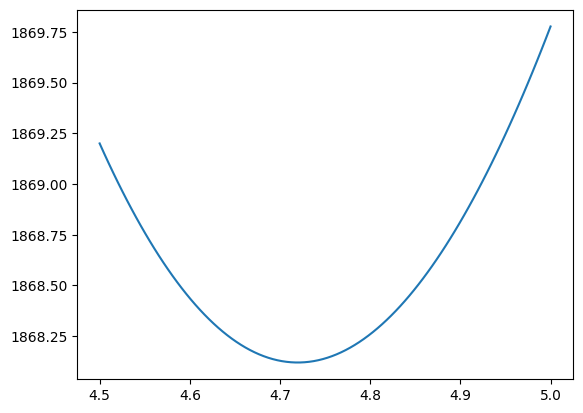

In [14]:
lambdas = np.linspace(4.5, 5, 100)
err = []

for lambda_ in lambdas:
    u = vartotale_Chambolle(imb, lambda_)
    err.append(norm2(u - im))
    #viewimage(u)

plt.plot(lambdas, err)
lambda_TV = lambdas[np.argmin(err)]

4.717171717171717


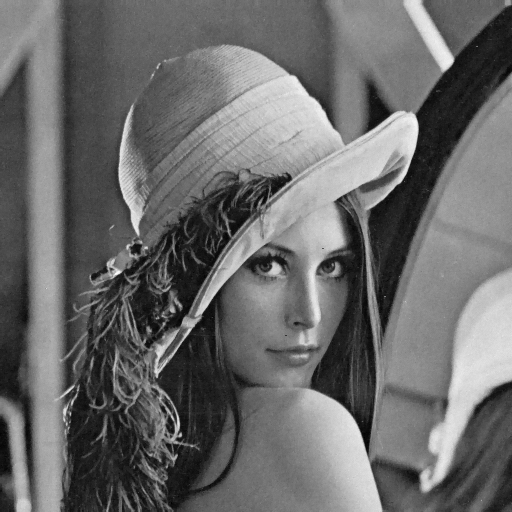

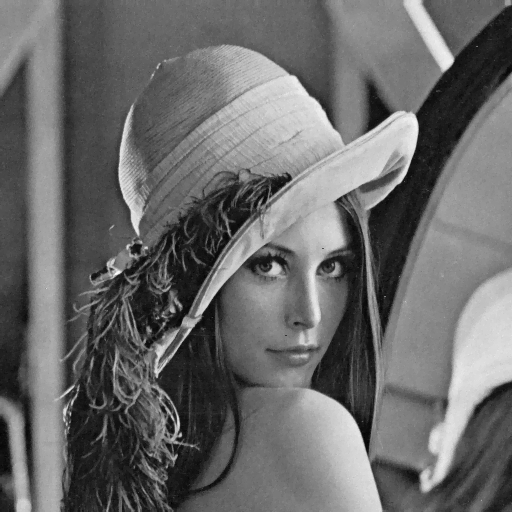

In [15]:
print(lambda_TV)
viewimage(minimise_TV_gradient(imb, 4.7, 0.21, 1_000)[0])
viewimage(vartotale_Chambolle(imb, 4.7))

Q7. Après avoir fixé une image bruitée par un bruit de 25. Trouver pour chacune des deux méthodes (TV et quadratique) le meilleur paramètre $\lambda$ et comparez qualitativement le résultat obtenu par les deux méthodes pour le débruitage.

In [35]:
imb = degrade_image(im, 25)

err = []

lambdas = np.linspace(0.1, 2, 1_000)
rests = []

for lambda_ in lambdas:
    restq = minimisation_quadratique(imb, lambda_)
    err.append(norm2(im - restq))

lambda_quad = lambdas[np.argmin(err)]
u_quad = minimisation_quadratique(imb, lambda_quad)
print(norm2(u_quad - im))

lambdas = np.linspace(40, 42, 1_000)
err = []

for lambda_ in lambdas:
    u = vartotale_Chambolle(imb, lambda_)
    err.append(norm2(u - im))

lambda_tv = lambdas[np.argmin(err)]
u_tv = vartotale_Chambolle(imb, lambda_tv)
print(norm2(u_tv - im))

5317.924443428457
4428.480579079459


1.1745745745745746 41.429429429429426


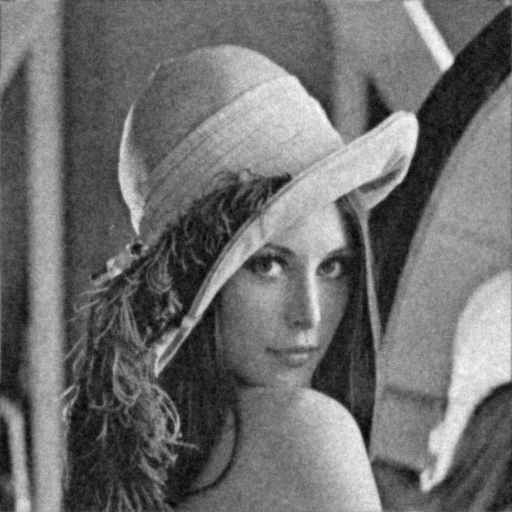

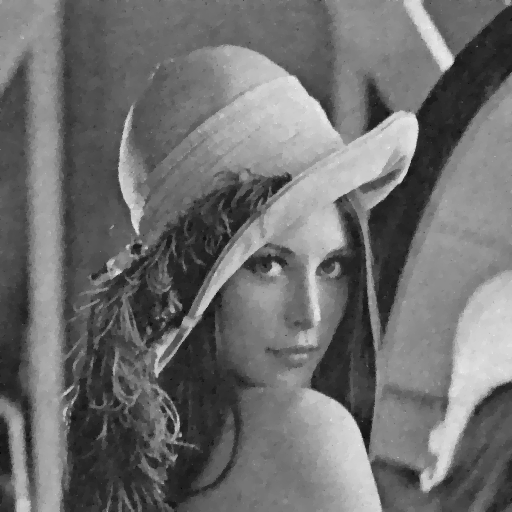

In [36]:
print(lambda_quad, lambda_tv)
viewimage(u_quad)
viewimage(u_tv)